#Introduction & Objective

This project focuses on developing a Retrieval-Augmented Generation (RAG) system for answering financial questions based on company 10-K filings. The system first retrieves relevant sections of financial reports and then generates accurate answers to user queries.

###Objective:
 Design a RAG-based pipeline that efficiently retrieves pertinent financial information and produces precise, contextually grounded answers to financial questions.

In [1]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")   # new dependency
nltk.download("stopwords")   # needed for stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install faiss-cpu
!pip install rouge_score
!pip install evaluate

In [32]:
import pandas as pd
import re
from collections import Counter
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy
from sentence_transformers import SentenceTransformer, InputExample, losses

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import faiss

import matplotlib.pyplot as plt
import seaborn as sns

import random
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import streamlit as st

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from pyngrok import ngrok
import time
import evaluate
import numpy as np

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset Overview: Financial-QA-10k

Description:
The Financial-QA-10k dataset contains 10,000 question-answer pairs extracted from company financial reports, specifically 10-K filings. It covers a broad range of topics relevant to financial analysis, company operations, and strategic insights, making it a valuable resource for researchers, data scientists, and finance professionals working in the financial NLP domain.

Each entry includes:

Question: The financial or operational query.

Answer: The specific answer to the question.

Context: Excerpt from the 10-K filing providing supporting information.

Ticker: Stock symbol of the company.

Filing Year: Year of the 10-K report from which the data was derived.

In [5]:
df = pd.read_csv("/content/Financial-QA-10k.csv")

In [6]:
df.head()

,question,answer,context,ticker,filing
0,What area did NVIDIA initially focus on before...,NVIDIA initially focused on PC graphics.,"Since our original focus on PC graphics, we ha...",NVDA,2023_10K
1,What are some of the recent applications of GP...,Recent applications of GPU-powered deep learni...,Some of the most recent applications of GPU-po...,NVDA,2023_10K
2,What significant invention did NVIDIA create i...,NVIDIA invented the GPU in 1999.,Our invention of the GPU in 1999 defined moder...,NVDA,2023_10K
3,How does NVIDIA's platform strategy contribute...,NVIDIA's platform strategy brings together har...,"NVIDIA has a platform strategy, bringing toget...",NVDA,2023_10K
4,What does NVIDIA's CUDA programming model enable?,NVIDIA's CUDA programming model opened the par...,With our introduction of the CUDA programming ...,NVDA,2023_10K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  6998 non-null   object
 1   answer    6998 non-null   object
 2   context   6999 non-null   object
 3   ticker    7000 non-null   object
 4   filing    7000 non-null   object
dtypes: object(5)
memory usage: 273.6+ KB


/tmp/ipython-input-551747575.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Count', y='ticker', data=ticker_counts, palette='viridis')


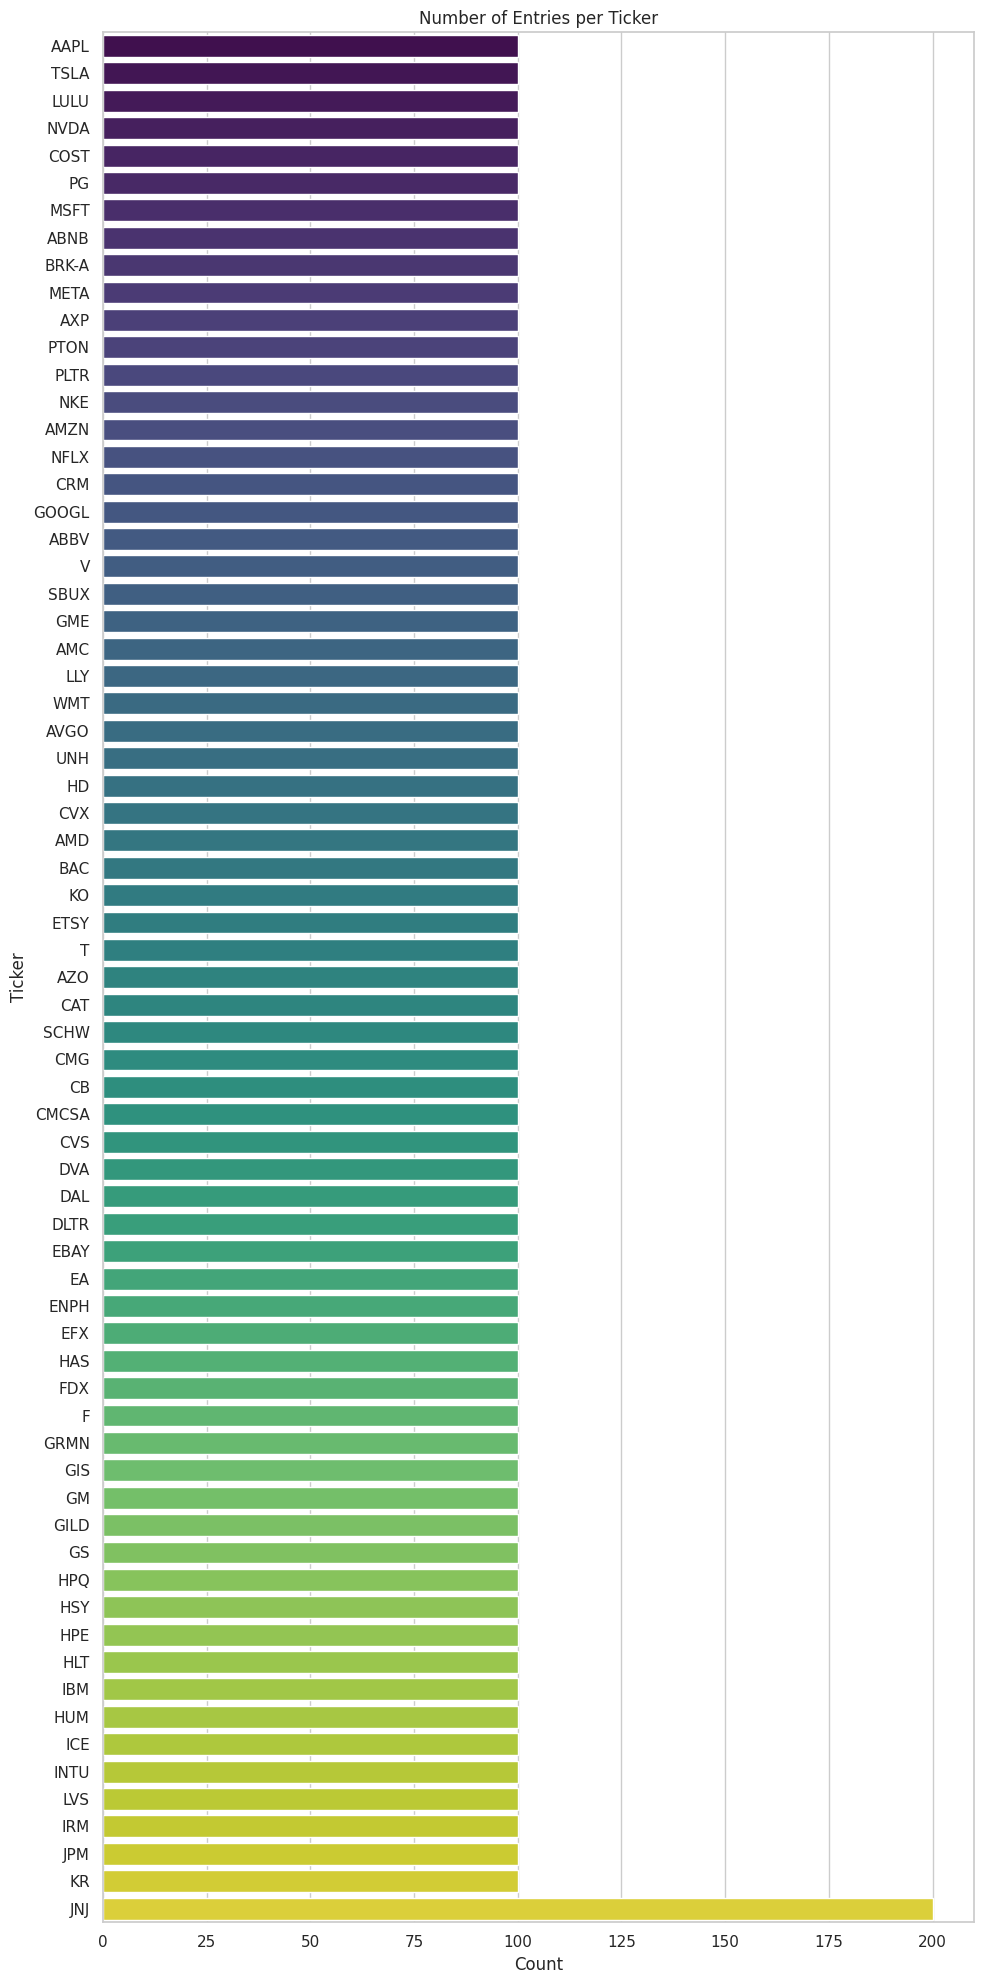

In [8]:
ticker_counts = df['ticker'].value_counts().reset_index()
ticker_counts.columns = ['ticker', 'Count']
ticker_counts = ticker_counts.sort_values('Count', ascending=True)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 20))
barplot = sns.barplot(x='Count', y='ticker', data=ticker_counts, palette='viridis')
plt.title('Number of Entries per Ticker')
plt.xlabel('Count')
plt.ylabel('Ticker')
plt.tight_layout()
plt.show()

The dataset is largely balanced across companies, with each ticker appearing 100 times. An exception is NVIDIA, which appears 200 times

In [9]:
num_unique = df['filing'].nunique()
print("Number of unique values in 'filing'':", num_unique)

unique_values = df['filing'].unique()
print("Unique values:", unique_values)

Number of unique values in 'filing'': 1
Unique values: ['2023_10K']


The 'filing' column contains only a single unique value, which means all data points correspond to the same filing year

In [10]:
def run_eda(dataframe, text_column="context"):
    for col in [text_column, "question", "answer"]:
        dataframe[f"{col}_word_count"] = dataframe[col].astype(str).apply(lambda x: len(word_tokenize(x)))

    stop_words = set(stopwords.words("english"))
    all_words = [w.lower() for text in dataframe[text_column].dropna() for w in word_tokenize(str(text))]
    words_alpha = [w for w in all_words if w.isalpha()]
    stopword_count = sum(1 for w in words_alpha if w in stop_words)
    stopword_pct = stopword_count / len(words_alpha) * 100 if len(words_alpha) > 0 else 0

    print(f"Percentage of stopwords in '{text_column}': {stopword_pct:.2f}%")

    for col in [text_column, "question", "answer"]:
        plt.figure(figsize=(8, 5))
        sns.histplot(dataframe[f"{col}_word_count"], bins=30, kde=True, color="skyblue", edgecolor="black")
        plt.xlabel("Word Count")
        plt.ylabel("Frequency")
        plt.title(f"Distribution of Word Counts in '{col}'")
        plt.show()

    common_words = Counter(words_alpha).most_common(10)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(counts), palette="viridis")
    plt.ylabel("Count")
    plt.xlabel("Word")
    plt.title(f"Top 10 Most Common Words in '{text_column}'")
    plt.show()

    print("\nMost common words and their counts:", common_words)


Percentage of stopwords in 'context': 37.74%


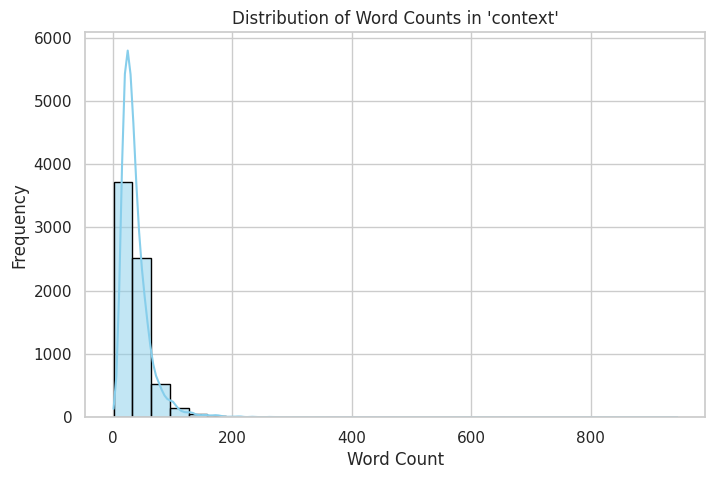

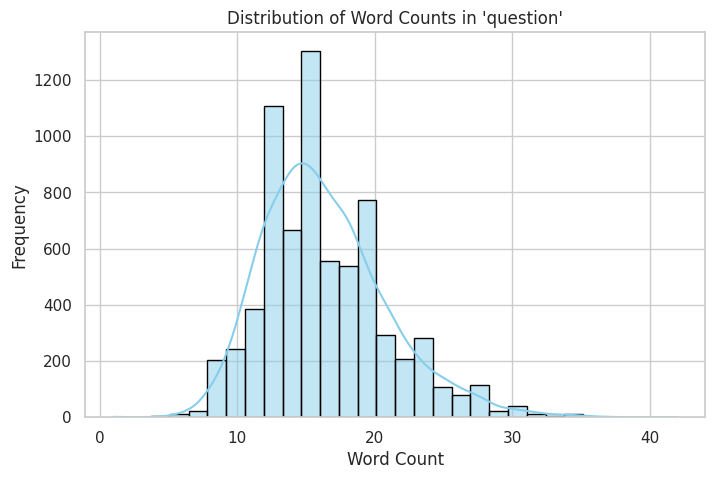

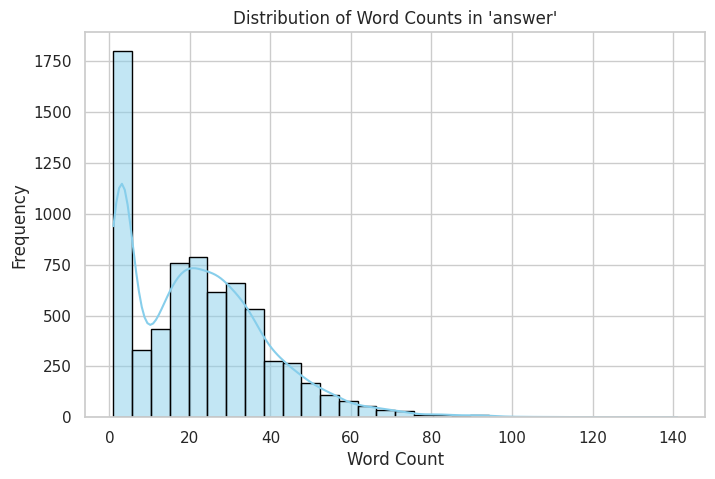

/tmp/ipython-input-2223746323.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


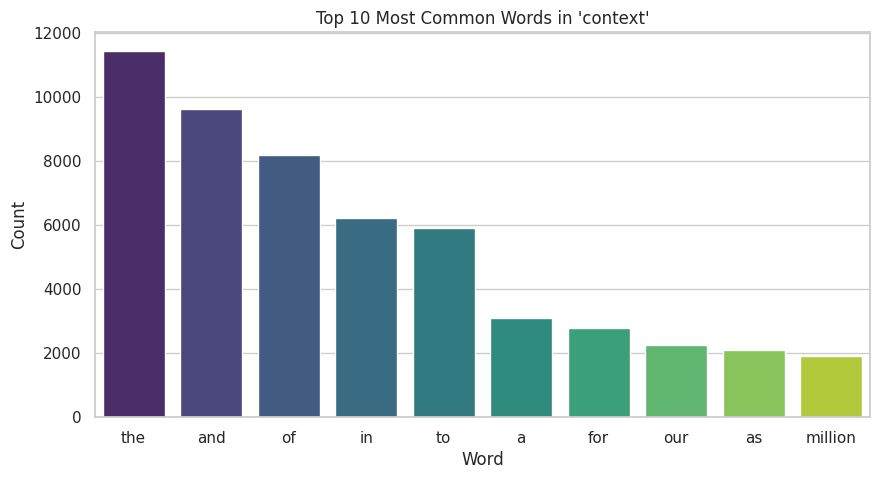


Most common words and their counts: [('the', 11451), ('and', 9614), ('of', 8189), ('in', 6229), ('to', 5916), ('a', 3108), ('for', 2781), ('our', 2252), ('as', 2094), ('million', 1905)]


In [11]:
run_eda(df)

In [12]:
df.isna().sum()

,0
question,2
answer,2
context,1
ticker,0
filing,0
context_word_count,0
question_word_count,0
answer_word_count,0


In [13]:
df = df.dropna()

In [14]:
df.duplicated(subset=['question','answer']).sum()

np.int64(31)

In [15]:
df= df.drop_duplicates().reset_index(drop=True)

## Text Cleaning

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'\s+', ' ', text).strip()  # normalize spaces
    return text


In [17]:
df['Context_clean'] = df['context'].apply(clean_text)
df['Question_clean'] = df['question'].apply(clean_text)

## Text Chuncking and Overlapping

Each context is divided into smaller, overlapping chunks for embedding, while maintaining a mapping to the original context. This ensures that every chunk, even when a context is split into multiple pieces, can be traced back to its source, allowing retrieved chunks to be accurately linked to the full original context.

In [18]:
def chunk_text_with_overlap(text, max_words=300, overlap=50):
    words = text.split()
    if len(words) <= max_words:
        return [' '.join(words)]  # properly indented

    chunks = []
    start = 0
    while start < len(words):
        end = start + max_words
        chunks.append(' '.join(words[start:end]))
        start += max_words - overlap

    return chunks


In [19]:
df['Context_clean'] = df['context'].apply(clean_text)
df['Question_clean'] = df['question'].apply(clean_text)


## Embedding the Context Column

In [20]:
retriever_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
all_chunks = []
context_ids = []

for idx, context in enumerate(df['Context_clean']):
    chunks = chunk_text_with_overlap(context)
    all_chunks.extend(chunks)
    context_ids.extend([idx]*len(chunks))

chunk_embeddings = retriever_model.encode(
    all_chunks, batch_size=64, show_progress_bar=True, convert_to_tensor=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

## Constructing a FAISS Index

A FAISS index is constructed over all chunk embeddings to enable efficient similarity search, while a mapping from each chunk to its original context and answer is maintained, allowing the RAG system to effectively retrieve relevant information for question answering

In [21]:
dim = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(chunk_embeddings.cpu().numpy())

context_map = {i: {"context": df.iloc[context_ids[i]]["context"],
                   "answer": df.iloc[context_ids[i]]["answer"]}
               for i in range(len(all_chunks))}

## Splitting the data into training, test and validation

In [22]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

## Building the Retriever

This function encodes a query into the embedding space, performs a similarity search in the FAISS index to retrieve the top-k most relevant chunks, and returns their corresponding original contexts and answers.

In [23]:
def retrieve(query, k=5):
    query_emb = retriever_model.encode([query], convert_to_tensor=True)
    D, I = index.search(query_emb.cpu().numpy(), k)
    results = [context_map[idx] for idx in I[0]]
    return results

## Fine-tuning the retriever

During fine-tuning, the model uses the training questions to update its weights so that the embeddings of contexts better reflect which questions they are relevant to. The contexts themselves are not stored with the questions — the model simply learns to position relevant contexts closer in the embedding space for new questions.

In [24]:
train_examples = [InputExample(texts=[row['Question_clean'], row['Context_clean']])
                  for _, row in train_df.iterrows()]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model=retriever_model)

retriever_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    show_progress_bar=True
)
retriever_model.save("fine_tuned_retriever_miniLM")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: Currently logged in as: manelbenamara14 (manelbenamara14-essai-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


In [25]:
k_values = [1, 3, 5]
best_k = 1
best_recall = 0

for k in k_values:
    hits = 0
    for q, true_context in zip(val_df['Question_clean'], val_df['Context_clean']):
        retrieved = retrieve(q, k=k)
        if any(true_context == r['context'] for r in retrieved):
            hits += 1
    recall = hits / len(val_df)
    print(f"Recall@{k}: {recall:.3f}")
    if recall > best_recall:
        best_recall = recall
        best_k = k

print(f"\nOptimal k for retrieval: {best_k} with Recall@{best_recall:.3f}")

Recall@1: 0.002
Recall@3: 0.004
Recall@5: 0.004

Optimal k for retrieval: 3 with Recall@0.004


## Loading the Flan-T5 Small Generator Model and Tokenizer

In [26]:
tokenizer_gen = AutoTokenizer.from_pretrained("google/flan-t5-small")
generator_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small").to(device)

## RAG-based Question Answering Function

In [79]:
def generate_answer_rag(question, k=5, max_length=200):
    contexts = retrieve(question, k)

    context_text = " ".join([c["context"] for c in contexts])

    prompt = f"Answer the question based on the context below:\nContext: {context_text}\nQuestion: {question}"

    # Generate answer using your Flan-T5 model
    inputs = tokenizer_gen(prompt, return_tensors="pt").to(device)
    outputs = generator_model.generate(**inputs, max_new_tokens=max_length)
    answer = tokenizer_gen.decode(outputs[0], skip_special_tokens=True)

    return answer

## Model Evaluation

In [ ]:
metric = evaluate.load("rouge")

In [80]:
def evaluate_rag_flant5(test_df, k=3, max_length=2000):
    gold_answers = []
    pred_answers = []

    # Loop through the whole test set
    for _, row in test_df.iterrows():
        question = row["Question_clean"]
        gold_answer = row["answer"]

        pred_answer = generate_answer_rag(question, k=k, max_length=max_length)

        gold_answers.append(gold_answer)
        pred_answers.append(pred_answer)

    exact_matches = [int(p.strip().lower() == g.strip().lower()) for p, g in zip(pred_answers, gold_answers)]
    em_score = float(np.mean(exact_matches))  # convert to plain float

    rouge_result = metric.compute(predictions=pred_answers, references=gold_answers)
    rouge_result = {k: float(v) for k, v in rouge_result.items()}  # convert np.float64 -> float

    print("\nEvaluation Results")
    print("=" * 40)
    print(f"Exact Match (EM): {em_score:.4f}")
    print(f"ROUGE-1:          {rouge_result['rouge1']:.4f}")
    print(f"ROUGE-2:          {rouge_result['rouge2']:.4f}")
    print(f"ROUGE-L:          {rouge_result['rougeL']:.4f}")
    print(f"ROUGE-Lsum:       {rouge_result['rougeLsum']:.4f}")
    print("=" * 40)

    return em_score, rouge_result


In [33]:
    exact_matches = [int(p.strip().lower() == g.strip().lower()) for p, g in zip(pred_answers, gold_answers)]
    em_score = float(np.mean(exact_matches))  # convert to plain float

    rouge_result = metric.compute(predictions=pred_answers, references=gold_answers)
    rouge_result = {k: float(v) for k, v in rouge_result.items()}

    print("\nEvaluation Results")
    print("=" * 40)
    print(f"Exact Match (EM): {em_score:.4f}")
    print(f"ROUGE-1:          {rouge_result['rouge1']:.4f}")
    print(f"ROUGE-2:          {rouge_result['rouge2']:.4f}")
    print(f"ROUGE-L:          {rouge_result['rougeL']:.4f}")
    print(f"ROUGE-Lsum:       {rouge_result['rougeLsum']:.4f}")
    print("=" * 40)

    return em_score, rouge_result

IndentationError: unexpected indent (ipython-input-1711347121.py, line 2)

In [30]:
evaluate_rag_flant5(test_df, k=3)

KeyboardInterrupt: 

### Evaluation Metrics

Exact Match (EM): Measures the percentage of predictions that are exactly identical to the reference answers.

0.0000 means the model never produced a perfect match with the gold answers.

ROUGE-1: Overlap of single words between prediction and reference.

0.2852 → about 28% word overlap.

ROUGE-2: Overlap of word pairs (bigrams).

0.1725 → around 17% bigram overlap, showing lower phrase-level similarity.

ROUGE-L / ROUGE-Lsum: Longest common subsequence, capturing fluency and structural similarity.

~0.23 → some alignment in longer word sequences but still modest.

In [82]:
def evaluate_rag_flant5_sample(test_df, k=3, max_length=200, n_examples=50):
    results = []
    gold_answers = []
    pred_answers = []

    # Prendre seulement n_examples si le df est grand
    subset_df = test_df.head(n_examples)

    for _, row in subset_df.iterrows():
        question = row["Question_clean"]
        gold_answer = row["answer"]

        pred_answer = generate_answer_rag(question, k=k, max_length=max_length)

        gold_answers.append(gold_answer)
        pred_answers.append(pred_answer)

        results.append({
            "question": question,
            "gold_answer": gold_answer,
            "pred_answer": pred_answer,
            "context": row["Context_clean"]
        })

    exact_matches = [int(p.strip().lower() == g.strip().lower()) for p, g in zip(pred_answers, gold_answers)]
    em_score = np.mean(exact_matches)

    rouge_result = metric.compute(predictions=pred_answers, references=gold_answers)

    print("Evaluation Results")
    print("=" * 40)
    print(f"Exact Match (EM): {em_score:.4f}")
    for key, value in rouge_result.items():
        print(f"{key.upper():<15}: {value:.4f}")

    print("\nSample Predictions:")
    for ex in results:
        print("=" * 80)
        print("Q: ", ex["question"])
        print("Context: ", ex["context"][:300], "..." if len(ex["context"]) > 300 else "")
        print("Gold Answer: ", ex["gold_answer"])
        print("Predicted Answer: ", ex["pred_answer"])

    return em_score, rouge_result



em_score, rouge_result = evaluate_rag_flant5_sample(test_df, k=3, max_length=200, n_examples=50)


Evaluation Results
Exact Match (EM): 0.1000
ROUGE1         : 0.2580
ROUGE2         : 0.1898
ROUGEL         : 0.2579
ROUGELSUM      : 0.2592

Sample Predictions:
Q:  what financial impact is expected from the accelerated retirement of 46 md-11f aircraft and related engines in 2023 at fedex express?
Context:  in the fourth quarter of 2023, fedex express made the decision to accelerate the retirement of 46 md-11f aircraft and related engines to aid in our fleet modernization, improve our global network, and better align air network capacity of fedex express to match current and anticipated shipment volume ...
Gold Answer:  The accelerated retirement is expected to result in a net increase of approximately $12 million in depreciation expense in 2024, with the expense impact in 2025 being immaterial.
Predicted Answer:  net increase of approximately $12 million in depreciation expense
Q:  what was the net cash provided by operating activities for the year ended december 31, 2023?
Context:  f

Exact Match (EM): Measures the percentage of predictions that are exactly identical to the reference answers.

0.1000 → The model produced an exact match for 10% of the examples, meaning most answers are not perfectly identical to the gold answers.

ROUGE-1: Overlap of single words between prediction and reference.

0.2580 → About 26% of the words in the predicted answers also appear in the reference answers.

ROUGE-2: Overlap of word pairs (bigrams).

0.1898 → Around 19% of bigrams are shared, indicating moderate similarity at the phrase level.

ROUGE-L / ROUGE-Lsum: Longest common subsequence, capturing fluency and structural similarity.

0.2579 / 0.2592 → The predicted answers have roughly 26% alignment in longer sequences, suggesting some structural similarity with the gold answers, but overall still limited.

## Web App

In [78]:
import gradio as gr

tokenizer_gen = AutoTokenizer.from_pretrained("google/flan-t5-small")
generator_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small").to(device)

def retrieve(query, k=3):
    query_emb = retriever_model.encode([query], convert_to_tensor=True)
    D, I = index.search(query_emb.cpu().numpy(), k)
    results = [context_map[idx] for idx in I[0]]
    return results

def generate_answer_rag(question, k=3, max_length=200):
    contexts = retrieve(question, k)

    context_text = " ".join([c["context"] for c in contexts])

    prompt = f"Answer the question based on the context below:\nContext: {context_text}\nQuestion: {question}"

    inputs = tokenizer_gen(prompt, return_tensors="pt").to(device)
    outputs = generator_model.generate(**inputs, max_new_tokens=max_length)
    answer = tokenizer_gen.decode(outputs[0], skip_special_tokens=True)
    return answer


custom_css = """
/* Full-page background */
.gradio-container {
    background-image: url('https://www.altexsoft.com/static/blog-post-featured/2023/10/1760192b-5099-4ef7-828c-cddb7d4b6184.jpg');
    background-size: cover;
    background-position: center;
    background-repeat: no-repeat;
}

/* Input and output boxes semi-transparent */
.gr-textbox, .gr-box {
    background-color: rgba(50, 50, 50, 0.7) !important;  /* dark grey with transparency */
    color: white !important;
}

/* Buttons slightly transparent grey */
.gr-button {
    background-color: rgba(80, 80, 80, 0.7) !important;  /* grey with transparency */
    color: white !important;
    border: 1px solid white !important;
}

/* On hover, slightly brighter */
.gr-button:hover {
    background-color: rgba(120, 120, 120, 0.8) !important;
}

/* Title text color */
.gr-title {
    color: white !important;
}
"""



iface = gr.Interface(
    fn=generate_answer_rag,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here...", label="Your Question"),
    outputs=gr.Textbox(label="Answer"),
    title="Fi-Lens",
    description="Ask any question",
    css=custom_css
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74fe1941166021d675.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
